<a href="https://colab.research.google.com/github/MoMahmoud8/image_coloraization/blob/main/imageColoriazation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mostafa mahmoud hassan--->20190545

SyntaxError: ignored



1.   List item
2.   List item



In [1]:

import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
!pip install patool


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 538 kB/s 


In [3]:
import patoolib


In [4]:
patoolib.extract_archive("/content/colordata.rar")
patoolib.extract_archive("/content/graydata.rar")


patool: Extracting /content/colordata.rar ...
patool: running /usr/bin/unrar x -- /content/colordata.rar
patool:     with cwd='./Unpack_joeu1ilb'
patool: ... /content/colordata.rar extracted to `colordata'.
patool: Extracting /content/graydata.rar ...
patool: running /usr/bin/unrar x -- /content/graydata.rar
patool:     with cwd='./Unpack__zshr5dd'
patool: ... /content/graydata.rar extracted to `graydata'.


'graydata'

In [5]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/colordata'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(image.img_to_array(img))


gray_img = []
path = '/content/graydata'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(image.img_to_array(img))

100%|██████████| 1608/1608 [00:01<00:00, 1573.29it/s]


In [8]:

# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

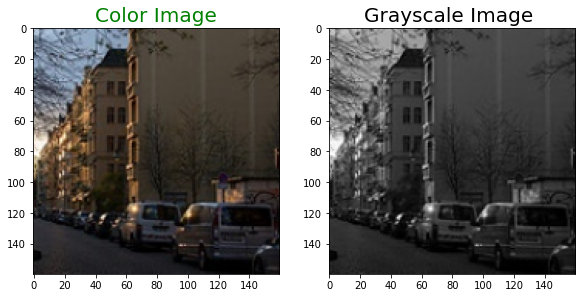

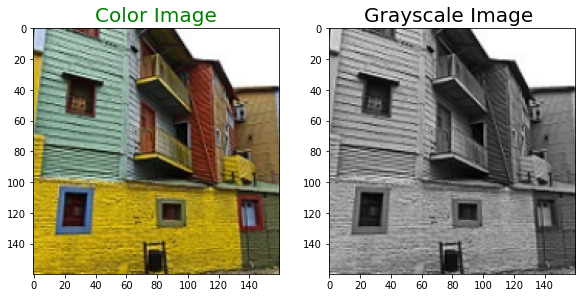

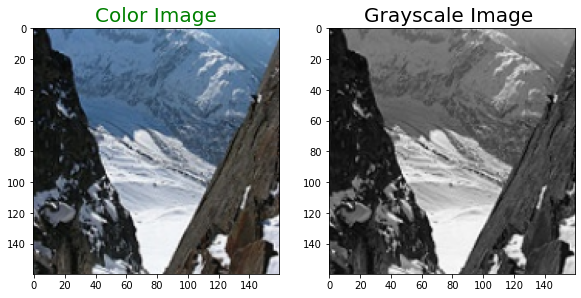

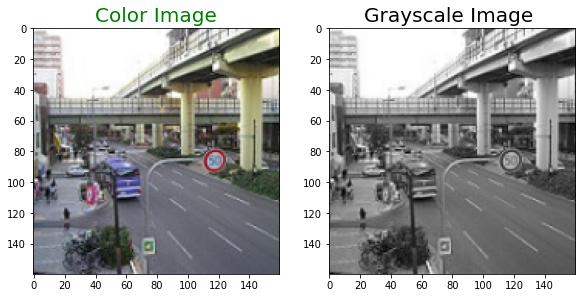

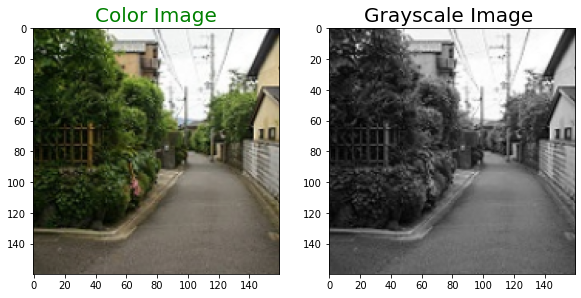

In [10]:
for i in range(5):
     plot_images(color_img[i],gray_img[i])

In [16]:

train_gray_image = gray_img[:1000]
train_color_image = color_img[:1000]

test_gray_image = gray_img[1000:]
test_color_image = color_img[1000:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (1000, 160, 160, 3)
Test color image shape (608, 160, 160, 3)


In [7]:

from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample
     

In [8]:

def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [9]:

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 200,batch_size = 128,verbose = 1)

Epoch 1/200
8/8 [==============================] - 10s 1s/step - loss: 0.0221 - acc: 0.8002
Epoch 2/200
8/8 [==============================] - 5s 588ms/step - loss: 0.0164 - acc: 0.8276
Epoch 3/200
8/8 [==============================] - 5s 593ms/step - loss: 0.0134 - acc: 0.8508
Epoch 4/200
8/8 [==============================] - 5s 593ms/step - loss: 0.0128 - acc: 0.8505
Epoch 5/200
8/8 [==============================] - 5s 598ms/step - loss: 0.0125 - acc: 0.8617
Epoch 6/200
8/8 [==============================] - 5s 598ms/step - loss: 0.0116 - acc: 0.8567
Epoch 7/200
8/8 [==============================] - 5s 602ms/step - loss: 0.0108 - acc: 0.8712
Epoch 8/200
8/8 [==============================] - 5s 605ms/step - loss: 0.0110 - acc: 0.8672
Epoch 9/200
8/8 [==============================] - 5s 602ms/step - loss: 0.0109 - acc: 0.8679
Epoch 10/200
8/8 [==============================] - 5s 605ms/step - loss: 0.0107 - acc: 0.8694
Epoch 11/200
8/8 [==============================] - 5s 611ms/

In [18]:
model.evaluate(test_gray_image,test_color_image)


19/19 [==============================] - 1s 65ms/step - loss: 0.0381 - acc: 0.5912


[0.038110002875328064, 0.5911995768547058]

1/1 [==============================] - 0s 483ms/step


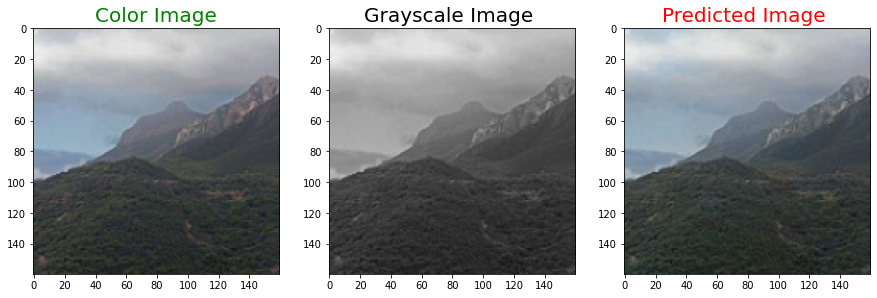

1/1 [==============================] - 0s 24ms/step


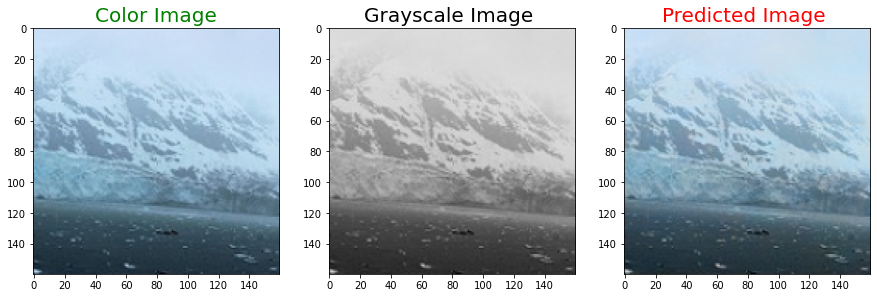

1/1 [==============================] - 0s 26ms/step


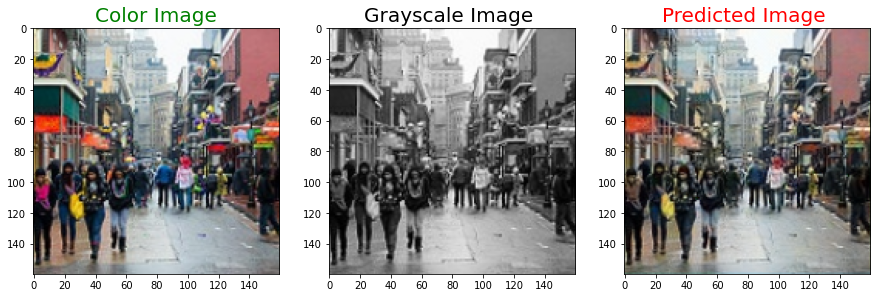

1/1 [==============================] - 0s 29ms/step


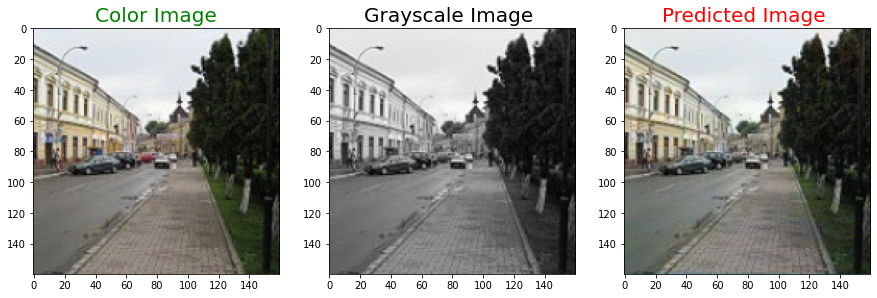

1/1 [==============================] - 0s 27ms/step


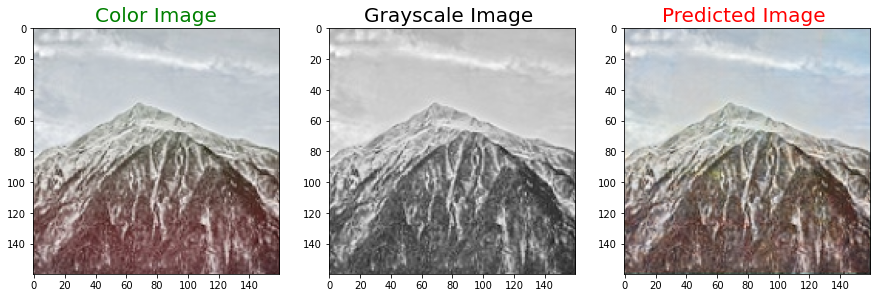

In [19]:

# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()
for i in range(5):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)